# Forecasting case-study: Bike sharing in Paris

```
Authors: Alexandre Gramfort
         Thomas Moreau
```

### Overview

Bike sharing systems allow users to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real-world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure, and arrival position is explicitly recorded in these systems. This feature turns the bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of the important events in the city could be detected via monitoring these data.

### Attribute Information

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features:

- counter name
- counter site name
- date
- counter installation date
- latitude and longitude

Available features are quite scarce. However, we can also use any **external data** that can help you to predict the target variable.

### Objective: forecast the number of bike rides

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

We will use the parquet format. We do not use a .csv file as parquet files are a lot faster to load and it produces much smaller files. It also allows to store the proper dtype of each column. You should consider it for your work!

In [2]:
df = pd.read_parquet(Path('data') / 'bike-counter-data.parquet')
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude
0,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,0.0,2020-09-01 02:00:00,2012-02-22,X2H20012081,48.83511,2.33338
1,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,0.0,2020-09-01 01:00:00,2012-02-22,X2H20012081,48.83511,2.33338
2,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,14.0,2020-09-01 05:00:00,2012-02-22,X2H20012081,48.83511,2.33338
3,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,7.0,2020-09-01 04:00:00,2012-02-22,X2H20012081,48.83511,2.33338
4,100003096-353242251,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau,3.0,2020-09-01 03:00:00,2012-02-22,X2H20012081,48.83511,2.33338


#### Let's first look at the target one wants to predict

One can see that the target is quite heavy tailed

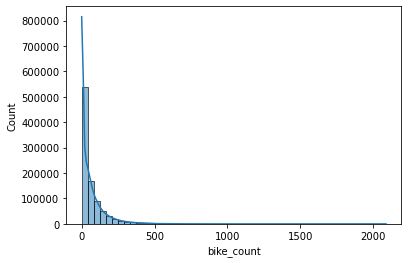

In [3]:
import seaborn as sns
ax = sns.histplot(df, x='bike_count', kde=True, bins=50)

## Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936649 entries, 0 to 936648
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 936649 non-null  category      
 1   counter_name               936649 non-null  category      
 2   site_id                    936649 non-null  int64         
 3   site_name                  936649 non-null  category      
 4   bike_count                 936649 non-null  float64       
 5   date                       936649 non-null  datetime64[ns]
 6   counter_installation_date  936649 non-null  datetime64[ns]
 7   counter_technical_id       930495 non-null  category      
 8   latitude                   936649 non-null  float64       
 9   longitude                  936649 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(3), int64(1)
memory usage: 46.5 MB


In [5]:
df.nunique(axis=0)

counter_id                     97
counter_name                   97
site_id                        70
site_name                      70
bike_count                   1037
date                         9908
counter_installation_date      36
counter_technical_id           69
latitude                       70
longitude                      70
dtype: int64

In [6]:
df.describe()

,site_id,bike_count,latitude,longitude
count,9.366490e+05,936649.000000,936649.000000,936649.000000
mean,1.032558e+08,61.171178,48.855573,2.343569
std,2.512007e+07,88.034268,0.020084,0.037416
min,1.000031e+08,0.000000,48.820240,2.265420
25%,1.000475e+08,4.000000,48.840150,2.314440
50%,1.000560e+08,29.000000,48.853720,2.352110
75%,1.000563e+08,82.000000,48.865020,2.374720
max,3.000147e+08,2088.000000,48.896960,2.409690


Let's look at the most used sites. Note that one can have 2 counters in one site.

In [7]:
df.groupby(['site_name', 'counter_name'])['bike_count'].sum().sort_values(
    ascending=False
).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,2270234.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1775289.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1724878.0
89 boulevard de Magenta NO-SE,89 boulevard de Magenta NO-SE,1583873.0
102 boulevard de Magenta SE-NO,102 boulevard de Magenta SE-NO,1535096.0
72 boulevard Voltaire NO-SE,72 boulevard Voltaire NO-SE,1367712.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1289885.0
72 boulevard Richard Lenoir S-N,72 boulevard Richard Lenoir S-N,1253107.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1189066.0


In [8]:
import folium

m = folium.Map(location=df[['latitude', 'longitude']].mean(axis=0), zoom_start=13)

for _, row in df[['counter_name', 'latitude', 'longitude']].drop_duplicates('counter_name').iterrows():
    folium.Marker(
    row[['latitude', 'longitude']].values.tolist(), popup=row['counter_name']
    ).add_to(m)

m

Next we will look into the temporal distribution of the most frequently used bike counters. If we plot it directly we will not see much because there are half a million data points.

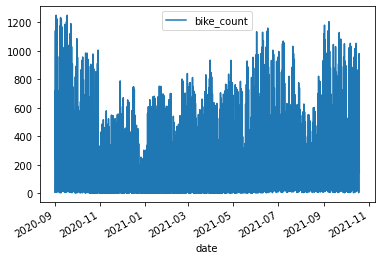

In [9]:
query_str = "counter_name == 'Totem 73 boulevard de Sébastopol S-N'"
_ = df.query(query_str).plot(x='date', y='bike_count')

Instead we aggregate the data, for instance, by week to have a clearer overall picture.

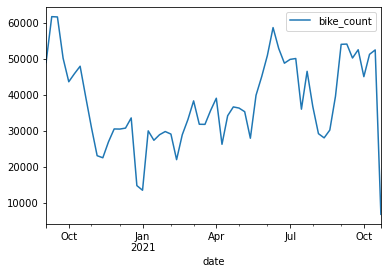

In [10]:
_ = df.query(query_str).groupby(pd.Grouper(freq='1w', key='date'))[['bike_count']].sum().plot()

While at the same time, we can zoom on a week in particular for a more short-term visualization:

<AxesSubplot:xlabel='date'>

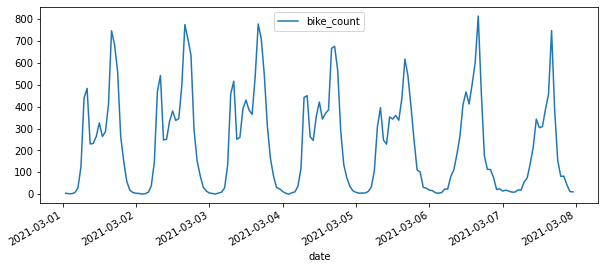

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
df.query(query_str + " and '2021/03/01' < date < '2021/03/08'").plot(x='date', y='bike_count', ax=ax)

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Plot the average bike_count per hour of the week (averaged over all sites).</li>
    </ul>
</div>

You should clearly distinguish the commute patterns in the morning and evenings of the work days
and the leisure use of the bikes on the weekends with a more spread peak demand around the middle of the days.

Solution is in `solutions/03-case_study_averaging_per_weekday_hour.py`

## Metrics

There are many possible metrics for regression tasks like here. For example:

### Mean Squared Error (MSE)

MSE = $\sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - y_i)^2}$

### Root Mean Squared Logarithmic Error (RMSLE)

RMSLE = $\sqrt{ \frac{1}{N} \sum_{i=1}^N (\log(x_i + 1) - \log(y_i + 1))^2 }$

### $R^2$ Score

$R^2=1-\frac{\sum_{i=1}^{n}e_i^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$

In what follows we will be using the RMSLE. For this we will be
creating a new column called `log_bike_count` using the `np.log1p`
function.

In [12]:
import numpy as np
df['log_bike_count'] = np.log1p(df['bike_count'])

## Feature extraction

In [13]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [14]:
df['date'].head()

0   2020-09-01 02:00:00
1   2020-09-01 01:00:00
2   2020-09-01 05:00:00
3   2020-09-01 04:00:00
4   2020-09-01 03:00:00
Name: date, dtype: datetime64[ns]

In [15]:
_encode_dates(df[['date']].head())

,year,month,day,weekday,hour
0,2020,9,1,1,2
1,2020,9,1,1,1
2,2020,9,1,1,5
3,2020,9,1,1,4
4,2020,9,1,1,3


In [16]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(df[['date']]).head()

,year,month,day,weekday,hour
0,2020,9,1,1,2
1,2020,9,1,1,1
2,2020,9,1,1,5
3,2020,9,1,1,4
4,2020,9,1,1,3


## Train and test data

We will now focus on one site and focus on the forecast of its bike count.

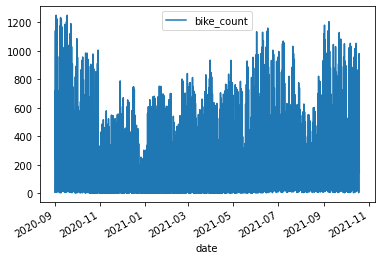

In [17]:
counter_name = 'Totem 73 boulevard de Sébastopol S-N'

data = df.query("counter_name == @counter_name")
data.plot(x='date', y="bike_count");

In [18]:
X, y = data.drop(['bike_count', 'log_bike_count'], axis='columns'), data['log_bike_count']
X = X[['date']]

In [19]:
n_samples_train = len(X) // 2
X_train, y_train = X[:n_samples_train], y[:n_samples_train]
X_test, y_test = X[n_samples_train:], y[n_samples_train:]

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

date_encoder = FunctionTransformer(_encode_dates)
regressor = Ridge()
selector = FunctionTransformer(
    lambda X: X[['weekday', 'hour']]
)
ohe = OneHotEncoder()

pipe = make_pipeline(date_encoder, selector, ohe, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x121aaf3a0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function <lambda> at 0x12186d940>)),
                ('onehotencoder', OneHotEncoder()), ('ridge', Ridge())])

In [21]:
from sklearn.metrics import mean_squared_error

print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.73
Test set, RMSE=0.84


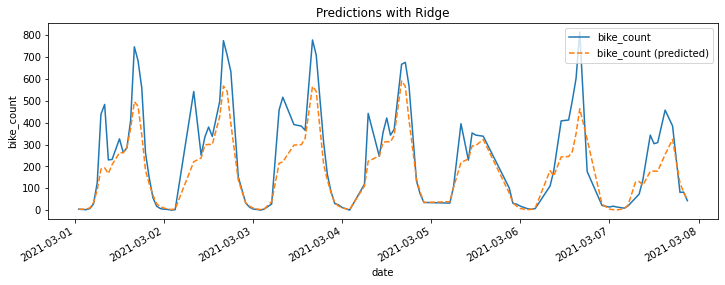

In [22]:
mask = ((X_test['date'] > pd.to_datetime('2021/03/01'))
        & (X_test['date'] < pd.to_datetime('2021/03/08')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

fig, ax = plt.subplots(figsize=(12, 4))
df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax, ls='--')
ax.set_title('Predictions with Ridge')
ax.set_ylabel('bike_count');

We can see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the morning and the evening are under-estimated.

A useful way to visualize the error is to plot y_pred as a function of y_true,

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

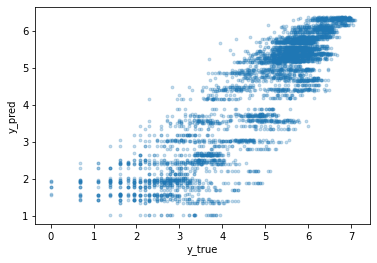

In [23]:
fig, ax = plt.subplots()
df_viz = pd.DataFrame({'y_true': y_test, 'y_pred': pipe.predict(X_test)})
df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.25, ax=ax)

Now let's do a proper cross-validation with `TimeSeriesSplit`:

In [24]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', -scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [0.92210611 0.76360137 0.73965295 0.64000198 0.78417818 0.62146924]
RMSE (all folds): 0.745 ± 0.0996


<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Modify the _encode_dates function to take into account the French holidays. And reevaluate the full pipeline above. Does it help significantly?</li>
    </ul>
</div>

Solution is in `solutions/03-french_holidays.py`

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Add interaction terms between one-hot encoded hour and weekdays in your model using <code>sklearn.preprocessing.PolynomialFeatures</code>. Does it help?</li>
    </ul>
</div>

Solution is in `solutions/03-polynomial_features.py`

So far we have only explore non-recurrent forecasting models.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the performance a Ridge model with an auto-regressive (AR) model
        from statsmodels or prophet.</li>
    </ul>
</div>